In [321]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v3 as iio
import os
os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"

import torch

import halftoner.halftoner_ours as ho
from halftoner.blue_loss import blue_loss
from halftoner.losspp import losspp

import skimage
from skimage.transform import resize
import pyiqa

In [325]:
device = torch.device("cuda")

cuda


In [421]:
root_dir = './pictures/original/'
target = 'salvataggio'

In [424]:
def make_halftoner(target_image, 
             init_image, 
             particles_types,
             particles_colors,
             sim_init_method,
             blur_kernel_size = 3,
             blur_sigma = 1,
             levels = 0):

    halftoner = ho.image_halftoner()
    halftoner.init_simulator(particles_colors, particles_types)
    halftoner.init_fields(target_image, init_image, sim_init_method, blur_kernel_size, blur_sigma, levels)
    halftoner.init_optimizer()

    return halftoner

def make_halftoner_path(image_path, 
             init_method, 
             init_method_args,
             particles_types,
             particles_colors,
             sim_init_method,):
    # Load the image
    target_image = np.atleast_3d( iio.imread(image_path) )

    # Generate the initial image
    init_image = ho.generate_init_image(target_image, init_method, **init_method_args)

    plt.imshow(init_image, cmap='gray')
    plt.title('Init image')
    plt.colorbar()
    plt.show()

    return make_halftoner(target_image,
                    init_image,
                    particles_types,
                    particles_colors,
                    sim_init_method,)


(2088, 4640, 3)


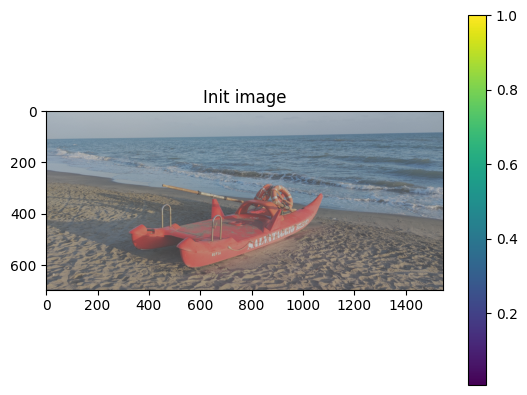

Init image shape: (696, 1546, 3)


In [427]:
# Try exr or png and stop on the first one that works

for ext in ['exr', 'png', 'jpg']:
    try:
        target_image_path = f'{root_dir}{target}.{ext}'
        target_image = np.atleast_3d( iio.imread(target_image_path) ).astype(np.float32)

        if ext == 'png' or ext == 'jpg':
            target_image = target_image / 255
        break
    except:
        pass

target_img = target_image[:2]

print(target_image.shape)

# Resize the image if needed
target_image  = skimage.transform.resize(target_image, np.array(target_image.shape[:2]) // 3)

# # Transform to grayscale if needed
# if target_image.shape[2] == 3:
#     target_image = np.atleast_3d( skimage.color.rgb2gray(target_image))

target_image_torch = torch.tensor(target_image, device=device).unsqueeze(0).permute(0, 3, 1, 2)

# init_method = 'blue'
# kwargs = {'value': 1e0}

# init_method = 'blue_dither'
# kwargs = {'blue_noise_path': './noise/blue_noise_0_1.npy'}

init_method = 'blue_add'
kwargs = { 'blue_noise_path': './noise/blue_noise_0_1.npy',
           'max_noise': 1}

# kwargs = { 'blue_noise_path': './noise/white_noise_256.npy',
#            'max_noise': 1}

# init_method = 'ostromoukhov'
# kwargs = {'multiplier': 255}

# init_method = 'uniform'
# kwargs = {'value': 1e-6}

# init_method = 'continuous'
# kwargs = {}

init_image = ho.generate_init_image(target_image, init_method, **kwargs)

plt.imshow(init_image)
plt.title('Init image')
plt.colorbar()
plt.show()

print(f'Init image shape: {init_image.shape}')

# Save the init picture if needed
# iio.imwrite('./pictures/init_images/init_image.png', (init_image[:,:,0]*255).astype(np.uint8))



In [428]:
# Single color
particles_colors =  np.array([[1]])


particles_types = np.array([[1]])

# Multi color
# particles_colors =  np.array([[1, 0, 0],
#                              [0, 1, 0],
#                              [0, 0, 1]])

# particles_types = np.array([[1, 0, 0],
#                             [0, 1, 0],
#                             [0, 0, 1]])

# Weird multicolor
# particles_types = np.array([[1, 0.2, 0],
#                             [0, 1, 0.5],
#                             [0.4, 0, 1]])

# Weird multicolor
# particles_types = np.array([[1, 1, 0],
#                             [0, .5, .5],
#                             [0, 0.5, 1]])

# Weird multicolor
# particles_types = np.array([[1, 0, 0],
#                             [0, .1, 0],
#                             [0, 0, 1]])

In [429]:
losses_objs = [
    {   'name' : 'mse',
        'weight': 1,
        'loss' : pyiqa.losses.losses.mse_loss,
        'loss_estimated_max': -1,
        'lower_better': True,
    },

    {   'name' : 'ssim',
        'weight': 1,
        'loss' : pyiqa.create_metric('ssim', device=device, as_loss=True),
        'loss_estimated_max': -1,
        'lower_better': False,
    },

    {   'name' : 'blue',
        'weight' : 5,
        'loss' : blue_loss(target_image_torch),
        'loss_estimated_max': -1,
        'lower_better': True,
    },

    # {   'name' : 'lpips',
    #     'weight': 1,
    #     'loss' : pyiqa.create_metric('lpips', device=device, as_loss=True),
    #     'loss_estimated_max': -1,
    #     'lower_better': True,
    # },
]

losses_objs = losspp(losses_objs)



original_image_dct shape:  torch.Size([1, 3, 696, 1546])


In [430]:
halftoner = make_halftoner(target_image,
                    init_image,
                    particles_types,
                    particles_colors,
                    'continuous',
                    blur_kernel_size= 11,
                    blur_sigma=1.5,
                    levels=0)

Initialized with 3 types and 3 colors
Field has shape (696, 1546, 1, 3) and we have 3 particle types,      for a total of 3228048 particles
Continuous init


[W 04/06/25 02:16:26.101 1246033] 
Assign may lose precision: unknown <- f32
[W 04/06/25 02:16:26.191 1246033] 
Assign may lose precision: unknown <- f32


In [431]:
halftoner.estimate_max_loss(losses_objs, './noise/blue_noise_0_1.npy')
for loss in losses_objs:
    print(f"Estimated max loss for {loss['name']}: {loss['loss_estimated_max']}")

(696, 1546, 1, 3)


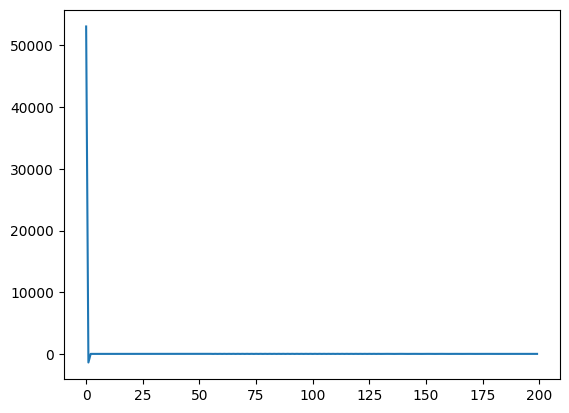

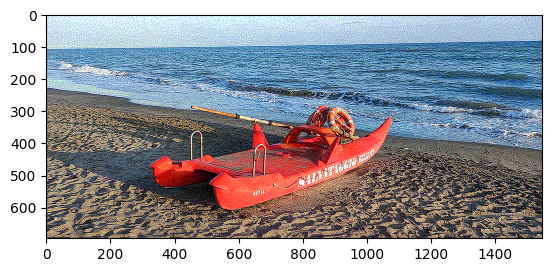

In [432]:
img, losses = halftoner.run_optimizer(200, losses_objs, initial_learning_rate=1e-1, show=False)
print(img.shape)
plt.plot(losses)
plt.show()

# plt.imshow(img[:,:,0,:], cmap='gray')
plt.imshow(img[:,:,0,:])

plt.show()


In [433]:
# Save the image
save_name = 'demo'

if img.shape[3] == 1:
    iio.imwrite(f'./pictures/tests/{target}_{save_name}.png', ( img[:,:,0,:]*255 ).astype(np.uint8) )
else:
    iio.imwrite(f'./pictures/tests/{target}_{save_name}.png', ( img[:,:,0,0]*255 ).astype(np.uint8) )